In [1]:
import qiskit

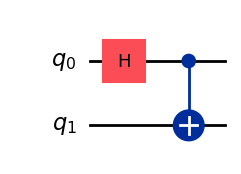

In [2]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0,1)

qc.draw(output="mpl")

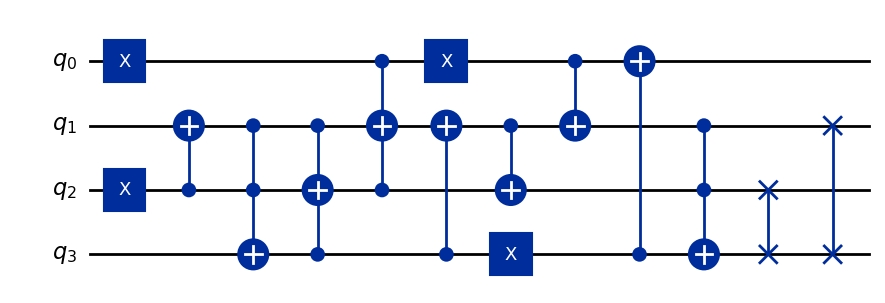

In [3]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# Build the circuit

qc = QuantumCircuit(4)
qc.x(0)
# qc.x(1)
qc.x(2)
#qc.x(3)
qc.cx(2, 1)
qc.ccx(1, 2, 3)
qc.ccx(1, 3, 2)
qc.ccx(0, 2, 1)
qc.cx(3, 1)
qc.x(0)
qc.x(3)
qc.cx(1, 2)
qc.cx(0, 1)
qc.cx(3, 0)
qc.ccx(1, 2, 3)
qc.swap(2, 3)
qc.swap(1, 3)

qc.draw(output="mpl")


{'0000': 1}


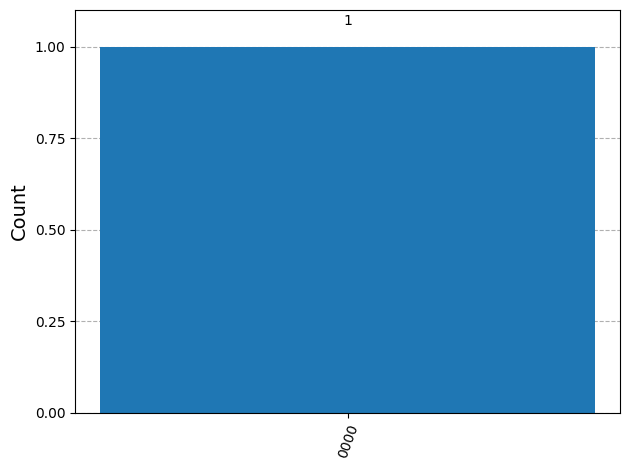

In [4]:
# Add measurement to all qubits
qc.measure_all()

# Use AerSimulator (the modern way)
simulator = AerSimulator()

# Execute the circuit
job = simulator.run(qc, shots=1)

# Get the results
result = job.result()
counts = result.get_counts()

# Display results
print(counts)
plot_histogram(counts)


10


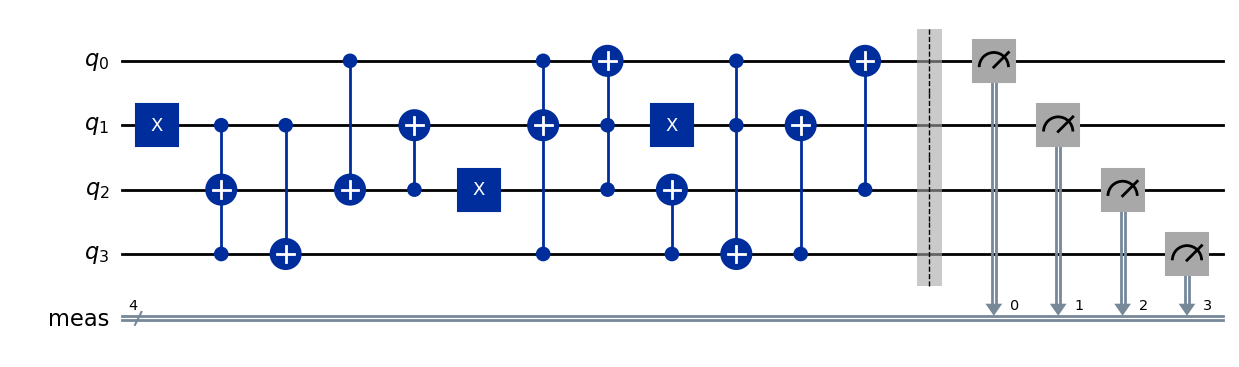

In [5]:
# from : 00FF 0F0F 3333 5555 
#F[0] = X[0];
#F[1] = X[2];
#F[2] = X[3];
#F[3] = X[1];

from qiskit import QuantumCircuit
import matplotlib.pyplot as plt
circuit = QuantumCircuit(4)

circuit.x(1)
circuit.ccx((3),(1),(2))
circuit.cx((1),(3))
circuit.cx((0),(2))
circuit.cx((2),(1))
circuit.x(2)
circuit.ccx((3),(0),(1))
circuit.ccx((2),(1),(0))
circuit.x(1)
circuit.cx((3),(2))
circuit.ccx((1),(0),(3))
circuit.cx((3),(1))
circuit.cx((2),(0))
circuit.measure_all()

print(circuit.depth()) #note that this is the non-decomposed depth
circuit.draw(output="mpl")
#X[0] = F[0];
#X[1] = F[3];
#X[2] = F[1];
#X[3] = F[2];

# to : E16C C395 A9C3 659A 
# T-Depth : 4
# Depth : 33

### Improved Sbox (with rearranged registers)

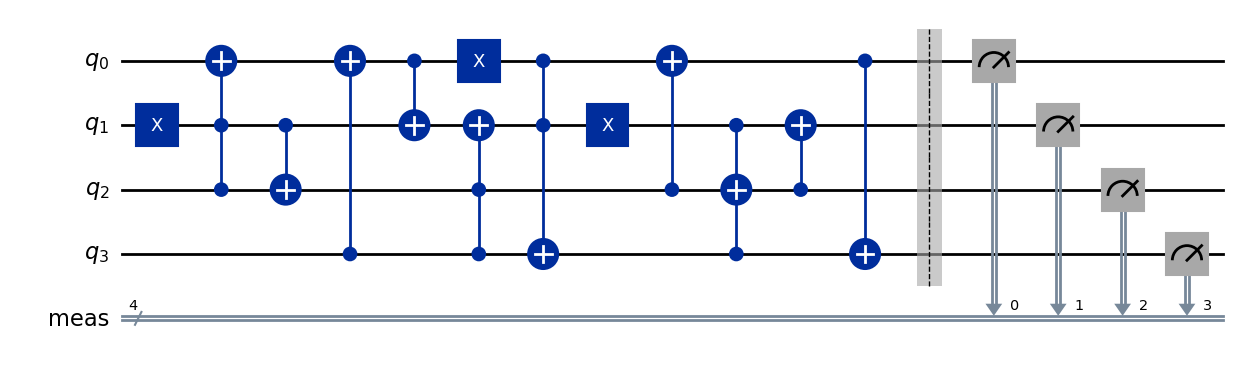

In [6]:
sbox_improved = QuantumCircuit(4)

sbox_improved.x(1)
sbox_improved.ccx(2,1,0)
sbox_improved.cx(1,2)
sbox_improved.cx(3,0)
sbox_improved.cx(0,1)
sbox_improved.x(0)
sbox_improved.ccx(3,2,1)
sbox_improved.ccx(1,0,3)
sbox_improved.x(1)
sbox_improved.cx(2,0)             
sbox_improved.ccx(3,1,2)          
sbox_improved.cx(2,1)             
sbox_improved.cx(0,3)             

sbox_improved.measure_all()

sbox_improved.draw(output="mpl")
    




In [7]:
# Use AerSimulator (the modern way)
simulator = AerSimulator()

# Execute the circuit
job = simulator.run(circuit, shots=1)

# Get the results
result = job.result()
counts = result.get_counts()

print(list(counts)[0])

1011


In [8]:
def build_sbox_circuit(input_bits: str):
    circuit = QuantumCircuit(4)
    
    init_map = [0, 2, 3, 1]

    for qubit, x_index in enumerate(init_map):
        if input_bits[x_index] == '1':
            circuit.x(qubit)

    circuit.x(1)
    circuit.ccx((3),(1),(2))
    circuit.cx((1),(3))
    circuit.cx((0),(2))
    circuit.cx((2),(1))
    circuit.x(2)
    circuit.ccx((3),(0),(1))
    circuit.ccx((2),(1),(0))
    circuit.x(1)
    circuit.cx((3),(2))
    circuit.ccx((1),(0),(3))
    circuit.cx((3),(1))
    circuit.cx((2),(0))

    return circuit

def build_improved_sbox_circuit(input_bits: str | None):
    circuit = QuantumCircuit(4)

    if input_bits:
        for qubit, value in enumerate(input_bits):
            if value == '1':
                circuit.x(3 - qubit)

    circuit.x(1)
    circuit.ccx(2,1,0)
    circuit.cx(1,2)
    circuit.cx(3,0)
    circuit.cx(0,1)
    circuit.x(0)
    circuit.ccx(3,2,1)
    circuit.ccx(1,0,3)
    circuit.x(1)
    circuit.cx(2,0)             
    circuit.ccx(3,1,2)          
    circuit.cx(2,1)             
    circuit.cx(0,3)             

    return circuit

def test_sbox_circuit(input_bits):
    assert len(input_bits) == 4

    circuit = build_sbox_circuit(input_bits)

    circuit.measure_all()
    
    simulator = AerSimulator()
    job = simulator.run(circuit, shots=1)
    result = job.result()
    counts = result.get_counts()

    raw = list(counts)[0]

    output = [''] * 4
    output[0] = raw[3]
    output[1] = raw[0]
    output[2] = raw[2]
    output[3] = raw[1]

    return hex(int(''.join(output), 2))[2:].upper(), circuit

def test_improved_sbox_circuit(input_bits):
    assert len(input_bits) == 4

    circuit = build_improved_sbox_circuit(input_bits)

    circuit.measure_all()
    
    simulator = AerSimulator()
    job = simulator.run(circuit, shots=1)
    result = job.result()
    counts = result.get_counts()

    output = list(counts)[0]

    return hex(int(output, 2))[2:].upper(), circuit

In [9]:
for input_number in range(0, 16):
    output, _ = test_improved_sbox_circuit(format(input_number, "04b"))
    print(f"{hex(input_number)[2:].upper()} : {output}")

0 : E
1 : D
2 : B
3 : 0
4 : 2
5 : 1
6 : 4
7 : F
8 : 7
9 : A
A : 8
B : 5
C : 9
D : C
E : 3
F : 6


In [10]:
def get_permuted_index(index, width):
    assert 0 <= index < width

    if 0 <= index <= width - 2:
        return int((index * width / 4) % (width - 1))
    else:
        return index
    

In [11]:
output_indexes = []
for i in range(0, 88):
    output_indexes.append(get_permuted_index(i, 88))
    print(f"{i} : {get_permuted_index(i, 88)}")

0 : 0
1 : 22
2 : 44
3 : 66
4 : 1
5 : 23
6 : 45
7 : 67
8 : 2
9 : 24
10 : 46
11 : 68
12 : 3
13 : 25
14 : 47
15 : 69
16 : 4
17 : 26
18 : 48
19 : 70
20 : 5
21 : 27
22 : 49
23 : 71
24 : 6
25 : 28
26 : 50
27 : 72
28 : 7
29 : 29
30 : 51
31 : 73
32 : 8
33 : 30
34 : 52
35 : 74
36 : 9
37 : 31
38 : 53
39 : 75
40 : 10
41 : 32
42 : 54
43 : 76
44 : 11
45 : 33
46 : 55
47 : 77
48 : 12
49 : 34
50 : 56
51 : 78
52 : 13
53 : 35
54 : 57
55 : 79
56 : 14
57 : 36
58 : 58
59 : 80
60 : 15
61 : 37
62 : 59
63 : 81
64 : 16
65 : 38
66 : 60
67 : 82
68 : 17
69 : 39
70 : 61
71 : 83
72 : 18
73 : 40
74 : 62
75 : 84
76 : 19
77 : 41
78 : 63
79 : 85
80 : 20
81 : 42
82 : 64
83 : 86
84 : 21
85 : 43
86 : 65
87 : 87


In [12]:
def lfsr(initial_state, taps, n_bits):
    # Initialize the state and prepare the result list
    state = list(map(int, initial_state))
    result = []
    
    # Generate n_bits of output
    for _ in range(n_bits):
        # Compute the feedback bit (XOR of tapped bits)
        feedback_bit = 0
        for tap in taps:
            feedback_bit ^= state[tap]
        
        # Append the feedback bit to the result
        result.append(state[-1])
        
        # Shift the register to the left and insert the feedback bit at the rightmost position
        state = [feedback_bit] + state[:-1]
    
    return ''.join(map(str, result))

# Parameters
initial_state = '101000'
taps = [4, 5]  # Positions of bits to XOR (counting from 0)
n_bits = 51

# Call the LFSR function
output_bits = lfsr(initial_state, taps, n_bits)
print(output_bits)

000101001111010001110010010110111011001101010111111


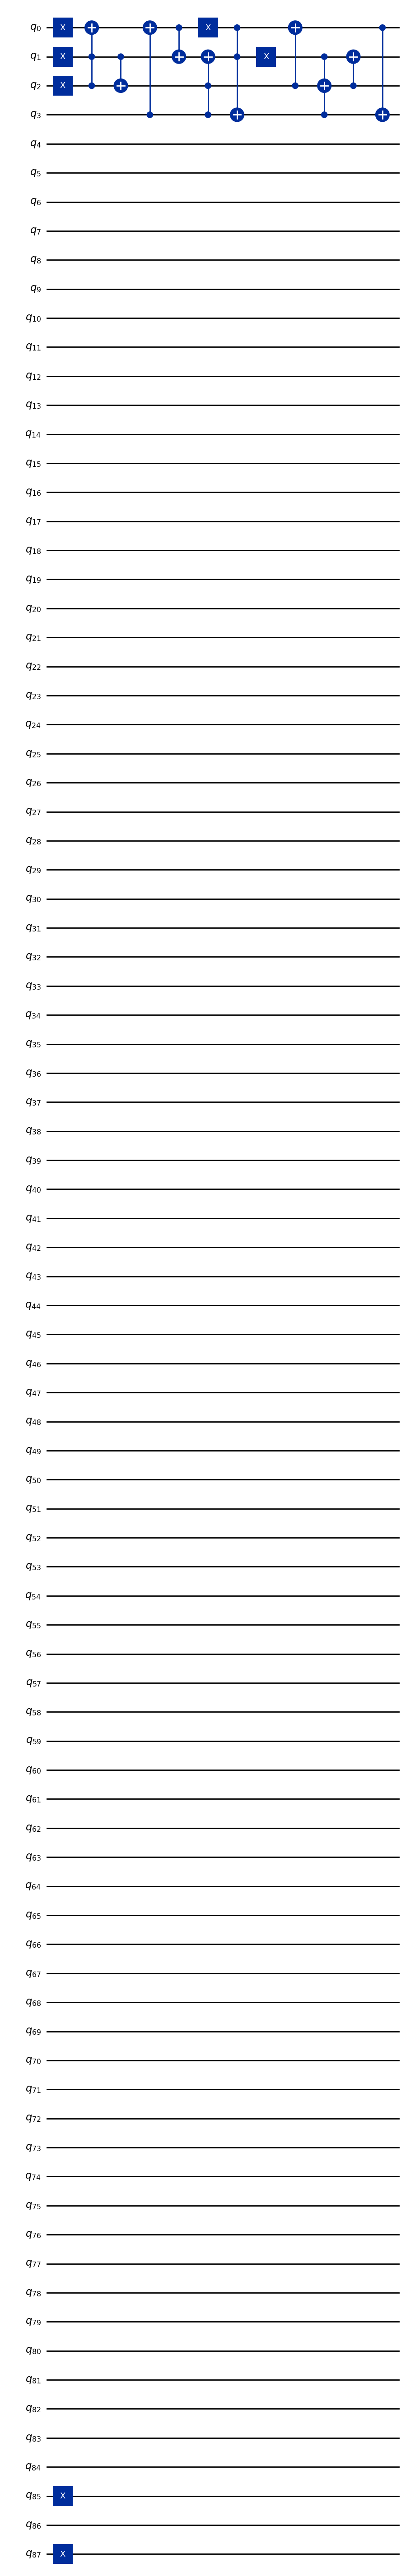

In [13]:
counter_bitstring = lfsr(initial_state, taps, n_bits)

def get_lfsr_state(round: int):
    return counter_bitstring[round:round+6]

def build_counter_layer(round: int):
    circuit = QuantumCircuit(88)
    lfsr_state = get_lfsr_state(round)
    reversed_lfsr_state = get_lfsr_state(round)[::-1]

    for i in range(0, 6):
        if lfsr_state[5 - i] == '1':
            circuit.x(i)
            circuit.x(87 - i)
    
    return circuit

def build_permutation_layer():
    circuit = QuantumCircuit(88)
    


counter_circuit = build_counter_layer(0)
sbox_circuit = build_improved_sbox_circuit(input_bits=None)

circuit = counter_circuit.compose(sbox_circuit, [0,1,2,3])



circuit.draw(output="mpl")



In [14]:
i = get_permuted_index(4, 20)
while(i != 4):
    print(i)
    i = get_permuted_index(i, 20)

1
5
6
11
17
9
7
16


In [15]:
for i, j in enumerate(list(range(20))):
    print(f"{i}:{get_permuted_index(j, 20)}")

0:0
1:5
2:10
3:15
4:1
5:6
6:11
7:16
8:2
9:7
10:12
11:17
12:3
13:8
14:13
15:18
16:4
17:9
18:14
19:19


In [16]:
{i: (i if i < 4 else i + 16) for i in range(20)}

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 20,
 5: 21,
 6: 22,
 7: 23,
 8: 24,
 9: 25,
 10: 26,
 11: 27,
 12: 28,
 13: 29,
 14: 30,
 15: 31,
 16: 32,
 17: 33,
 18: 34,
 19: 35}